# Channel Flow

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v} + [F_x=1, F_y=0]$$

$$ \nabla^2 p = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right) $$

(note: in practice a $ \frac{\partial}{\partial t}(\nabla \cdot \vec{v})$ term is retained in the pressure poisson equation as a means to drive $\nabla \cdot \vec{v}$ to zero)

Boundary Conditions

$$ u,v = \begin{cases}
\begin{matrix}
0~at~y=0 \cr
0 ~at~y=2\end{matrix}\end{cases} $$

$$ \frac{\partial p }{\partial y} = \begin{cases}
\begin{matrix}
0~at~y=0 \cr
0 ~at~y=2\end{matrix}\end{cases} $$

$$ F_x = 1 ~everywhere $$

$$u,v,p ~periodic ~on ~x=0,2$$

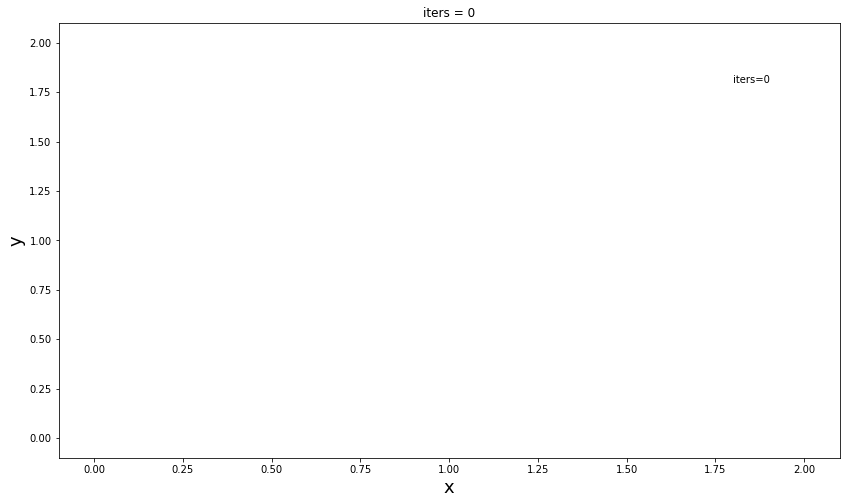

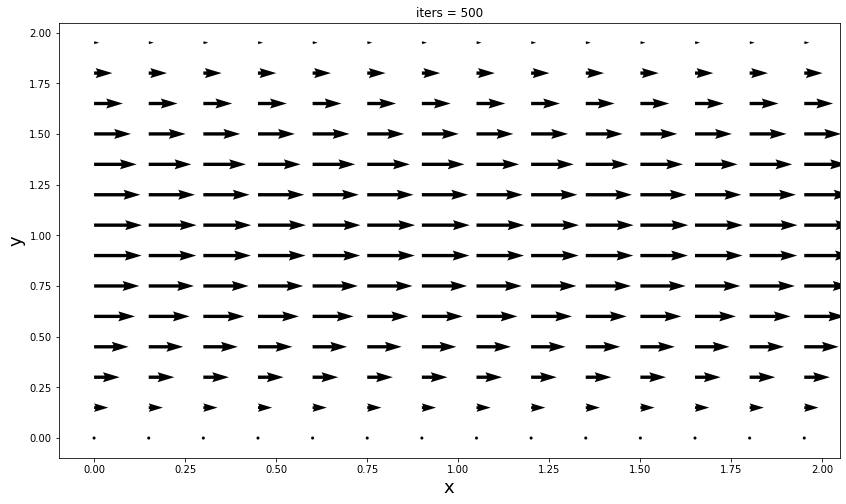

In [16]:
# Explicit pressure based scheme for Navier Stokes Equations

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation
from IPython.display import Video


# fluid properties
rho = 1
nu  = 0.1

# flow properties
F = 1

# domain limits
x_start, x_end = 0, 2
y_start, y_end = 0, 2

# number of grid points
nodes_x = 41
nodes_y = 41

# step sizes
dx = (x_end - x_start)/(nodes_x - 1)
dy = (y_end - y_start)/(nodes_y - 1)
dt = 0.01

# number of time steps
steps_n = 500

# number of sub iterations for pressure poisson equation
steps_n2 = 500

# generate grid
x = np.linspace(x_start, x_end, nodes_x)
y = np.linspace(x_start, x_end, nodes_y)
X, Y = np.meshgrid(x, y)

# initialize solution matrix
p = np.zeros(np.shape(X))
u = np.zeros(np.shape(X))
v = np.zeros(np.shape(X))

# set up matrices P,U,V to store full solution for each iteration
dim = list(np.shape(X))
dim.append(steps_n)
P = np.zeros(dim)
U = np.zeros(dim)
V = np.zeros(dim)

# builds RHS of Pressure Poisson Equation
def build_H(u,v,rho,dx,dy,dt):
    
    H = np.zeros(np.shape(u))
    H[1:-1, 1:-1]  = (u[1:-1, 2:] - u[1:-1, :-2]) / (2*dx*dt)
    H[1:-1, 1:-1] += (v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dy*dt)
    H[1:-1, 1:-1] -= (u[1:-1, 2:] - u[1:-1, :-2])**2 / (4*dx**2)
    H[1:-1, 1:-1] -= (u[2:, 1:-1] - u[:-2, 1:-1]) * (v[1:-1, 2:] - v[1:-1, :-2]) / (2*dx*dy)
    H[1:-1, 1:-1] -= (v[2:, 1:-1] - v[:-2, 1:-1])**2 / (4*dy**2)
    
    # periodic BC at x=2
    H[1:-1, -1]  = (u[1:-1, 0] - u[1:-1, -2]) / (2*dx*dt)
    H[1:-1, -1] += (v[2:, -1] - v[:-2, -1]) / (2*dy*dt)
    H[1:-1, -1] -= (u[1:-1, 0] - u[1:-1, -2])**2 / (4*dx**2)
    H[1:-1, -1] -= (u[2:, -1] - u[:-2, -1]) * (v[1:-1, 0] - v[1:-1, -2]) / (2*dx*dy)
    H[1:-1, -1] -= (v[2:, -1] - v[:-2, -1])**2 / (4*dy**2)
    
    # periodic BC at x=0
    H[1:-1, -1]  = (u[1:-1, 1] - u[1:-1, -1]) / (2*dx*dt)
    H[1:-1, -1] += (v[2:, 0] - v[:-2, 0]) / (2*dy*dt)
    H[1:-1, -1] -= (u[1:-1, 1] - u[1:-1, -1])**2 / (4*dx**2)
    H[1:-1, -1] -= (u[2:, 0] - u[:-2, 0]) * (v[1:-1, 1] - v[1:-1, -1]) / (2*dx*dy)
    H[1:-1, -1] -= (v[2:, 0] - v[:-2, 0])**2 / (4*dy**2)
    
    return rho*H

# does steps_n2 jacobi iteration on p
def solve_poisson(p, H, dx, dy, steps_n2):
    
    # some convinient definitions
    w1 = dy**2 / (2 * (dx**2 + dy**2))
    w2 = dx**2 / (2 * (dx**2 + dy**2))
    w3 = (dx**2 * dy**2) / (2 * (dx**2 + dy**2))
    
    for n in range(steps_n2):      
        p2 = p.copy()
        p2[1:-1,1:-1]  = w1 * (p[1:-1, 2:] + p[1:-1, :-2])
        p2[1:-1,1:-1] += w2 * (p[2:, 1:-1] + p[:-2, 1:-1])
        p2[1:-1,1:-1] -= w3 * H[1:-1, 1:-1]
        
        # Periodic BC at x=2
        p2[1:-1, -1]  = w1 * (p[1:-1, 0] + p[1:-1, -2])
        p2[1:-1, -1] += w2 * (p[2:, -1] + p[:-2, -1])
        p2[1:-1, -1] -= w3 * H[1:-1, -1]
        
        # Periodic BC at x=0
        p2[1:-1, 0]  = w1 * (p[1:-1, 1] + p[1:-1, -1])
        p2[1:-1, 0] += w2 * (p[2:, 0] + p[:-2, 0])
        p2[1:-1, 0] -= w3 * H[1:-1, 0]
        
        # enforce bc
        p2[-1, :] = p2[-2, :]   # p_y=0 at y=2
        p2[0, :]  = p2[1, :]    # p_y=0 at y=0

    
    return p2

# solves momentum equation
# first argument indicates 'u' or 'v' momentum equation
def solve_momentum(equation, u, v, p, F, rho, nu, dx, dy, dt):
           
    if equation == 'u':
        A = u
        A2  = A.copy() 
        A2[1:-1, 1:-1] -= (dt/dx) * (0.5/rho) * (p[1:-1, 2:] - p[1:-1, :-2])
        
        Fx = np.ones(np.shape(u)) * F
        A2[1:-1, :] += Fx[1:-1, :] * dt
    
    elif equation == 'v':
        A = v
        A2  = A.copy() 
        A2[1:-1, 1:-1] -= (dt/dy) * (0.5/rho) * (p[2:, 1:-1] - p[:-2, 1:-1])
    
    A2[1:-1, 1:-1] -= (dt/dx) * u[1:-1, 1:-1] * (A[1:-1, 1:-1] - A[1:-1, :-2])
    A2[1:-1, 1:-1] -= (dt/dy) * v[1:-1, 1:-1] * (A[1:-1, 1:-1] - A[:-2, 1:-1])    
    A2[1:-1, 1:-1] += (nu * dt / dx**2) * (A[1:-1, 2:] - 2*A[1:-1, 1:-1] + A[1:-1, :-2])
    A2[1:-1, 1:-1] += (nu * dt / dy**2) * (A[2:, 1:-1] - 2*A[1:-1, 1:-1] + A[:-2, 1:-1])
    
    # periodic BC at x=2
    A2[1:-1, -1] -= (dt/dx) * u[1:-1, -1] * (A[1:-1, -1] - A[1:-1, -2])
    A2[1:-1, -1] -= (dt/dy) * v[1:-1, -1] * (A[1:-1, -1] - A[:-2, -1])    
    A2[1:-1, -1] += (nu * dt / dx**2) * (A[1:-1, 0] - 2*A[1:-1, -1] + A[1:-1, -2])
    A2[1:-1, -1] += (nu * dt / dy**2) * (A[2:, -1] - 2*A[1:-1, -1] + A[:-2, -1])
    
    # periodic BC at x=0
    A2[1:-1, 0] -= (dt/dx) * u[1:-1, 0] * (A[1:-1, 0] - A[1:-1, -1])
    A2[1:-1, 0] -= (dt/dy) * v[1:-1, 0] * (A[1:-1, 0] - A[:-2, 0])    
    A2[1:-1, 0] += (nu * dt / dx**2) * (A[1:-1, 1] - 2*A[1:-1, 0] + A[1:-1, -1])
    A2[1:-1, 0] += (nu * dt / dy**2) * (A[2:, 0] - 2*A[1:-1, 0] + A[:-2, 0])
    
    return A2
    
# plot initial values and set-up for moving plot animation
fig, ax  = plt.subplots(figsize=[14, 8])
ax.set_title("iters = 0")
ax.text(1.8,1.8,"iters=0")
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("y", fontsize=18) 
Vfield1 = ax.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
           

    
#==== SOLVE CHANNEL FLOW ========
for n in range(steps_n):
    
    # solve pressure poisson and update p
    H = build_H(u,v,rho,dx,dy,dt)
    p = solve_poisson(p, H, dx, dy, steps_n2)
    
    # solve momentum equations with updated p
    # update u,v
    un = u.copy()
    vn = v.copy()
    u = solve_momentum('u', un, vn, p, F, rho, nu, dx, dy, dt)
    v = solve_momentum('v', un, vn, p, F, rho, nu, dx, dy, dt)
    
   
    
    # apply boundary conditions
    #   no slip on walls
    u[0, :]  = 0
    u[-1, :] = 0
    v[-1, :] = 0
    v[0, :]  = 0

    
    # record solution for animation
    P[:, :, n] = p
    U[:, :, n] = u
    V[:, :, n] = v
    
# plot final condition
fig_n, ax_n  = plt.subplots(figsize=[14, 8])
ax_n.set_title("iters = {}".format(steps_n))
ax_n.set_xlabel("x", fontsize=18)
ax_n.set_ylabel("y", fontsize=18)
Vfield_n = ax_n.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3])


In [17]:
# create animation of the solution
skip=1
def animate(n):
    
    ax.clear()
    ax.set_title("Channel Flow", fontsize=20)
    ax.text(2, 2.1, "iters = {}".format(n), fontsize=18)
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    Vfield1 = ax.quiver(X[::2, ::2], Y[::2, ::2], U[::2, ::2, n], V[::2, ::2, n])
        
    return Vfield1

ani = animation.FuncAnimation(fig, animate, interval=25, save_count=499, blit=False)

#int(steps_n/skip)

# supress static figure from being plotted
plt.close()
plt.close()

ani.save("Channel_Flow.mp4") # save as mp4
Video("Channel_Flow.mp4")    # display video in console